First download the hymenoptera datasat

In [1]:
from pathlib import Path
import zipfile
from loguru import logger

In [2]:
def get_hymenoptera():
    datadir = Path.home() / ".cache/mads_datasets/hymenoptera_data"
    url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
    if not datadir.exists():
        logger.info(f"Creating directory {datadir}")
        datadir.mkdir(parents=True)

        response = requests.get(url)
        zip_file_path = datadir / "hymenoptera_data.zip"
        with open(zip_file_path, "wb") as f:
            f.write(response.content)

        logger.info(f"Extracting {zip_file_path}")
        with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
            zip_ref.extractall(datadir)
        zip_file_path.unlink()
    else:
        logger.info(f"Directory {datadir} already exists, skipping download.")
    return datadir / "hymenoptera_data"

datadir = get_hymenoptera()

2025-10-13 12:04:31.020 | INFO     | __main__:get_hymenoptera:18 - Directory /Users/wouter/.cache/mads_datasets/hymenoptera_data already exists, skipping download.


Then print the output to check what is inside.

In [3]:
from pathlib import Path
import os

datadir = get_hymenoptera()

# print het pad zelf
print("Dataset directory:", datadir)

# print de inhoud van de hoofdfolder
print("Inhoud van de dataset folder:")
for item in datadir.iterdir():
    print(" -", item)

# eventueel ook dieper kijken in train/val
train_dir = datadir / "train"
val_dir = datadir / "val"

print("\nTrain classes:")
for cls in train_dir.iterdir():
    print(f" - {cls.name}: {len(list(cls.iterdir()))} images")

print("\nValidation classes:")
for cls in val_dir.iterdir():
    print(f" - {cls.name}: {len(list(cls.iterdir()))} images")

2025-10-13 12:04:31.025 | INFO     | __main__:get_hymenoptera:18 - Directory /Users/wouter/.cache/mads_datasets/hymenoptera_data already exists, skipping download.


Dataset directory: /Users/wouter/.cache/mads_datasets/hymenoptera_data/hymenoptera_data
Inhoud van de dataset folder:
 - /Users/wouter/.cache/mads_datasets/hymenoptera_data/hymenoptera_data/train
 - /Users/wouter/.cache/mads_datasets/hymenoptera_data/hymenoptera_data/val

Train classes:
 - bees: 121 images
 - ants: 124 images

Validation classes:
 - bees: 83 images
 - ants: 70 images


Hypothesis:
A convolutional neural network with multiple conv2d layers, batch normalization, and dropout will achieve higher classification accuracy on the hymenoptera dataset than a simple linear model, because the spatial structure in the images (wings, body shape, antennae) can be better captured by convolutional layers.

Setting Up the Environment & Imports

This initial step prepares our workspace. We import all the necessary libraries for this project:
- torch & torchvision: The core libraries for building our neural network and handling image data.
- ray, tune, & air: Ray Tune is the powerful library we use for running and managing our hyperparameter tuning experiments.
- pandas & seaborn: These are used for analyzing and visualizing the results of our tuning runs.
- pathlib: A modern way to handle file paths, ensuring the code works across different operating systems.

I also check for the availability of a GPU (cuda) and set it as my DEVICE if possible, which significantly speeds up training.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ray import tune, air
from ray.tune.search.basic_variant import BasicVariantGenerator

# Controle: Print de PyTorch versie om te zien of alles correct is geïnstalleerd
print(f"PyTorch versie: {torch.__version__}")
print(f"CUDA beschikbaar: {torch.cuda.is_available()}")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Actief apparaat: {DEVICE}")

# De datadir die je al had gedefinieerd
datadir = Path.home() / ".cache/mads_datasets/hymenoptera_data/hymenoptera_data"

2025-10-13 12:04:32,282	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-10-13 12:04:32,362	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


PyTorch versie: 2.8.0
CUDA beschikbaar: False
Actief apparaat: cpu


Preparing the Data (DataLoaders)

Before we can train a model, we need to load and process our image data. I did this in the folowing steps:
- data_transforms: This is a crucial preprocessing step. All images are resized to a standard 224x224 format and their pixel values are normalized. For the training set, we also apply data augmentation (RandomResizedCrop, RandomHorizontalFlip). This creates slightly modified versions of the images in each epoch, which helps the model learn more robust features and prevents it from simply memorizing the training data.
- ImageFolder: This PyTorch utility automatically loads images from subdirectories and assigns the correct labels (in this case, 'ants' and 'bees').
- DataLoader: This wraps the dataset and feeds the data to the model in manageable batches during training. Setting shuffle=True ensures the data is presented in a random order each epoch, which improves training stability.

Finally, I performed a visual check by displaying a batch of images to confirm that everything has been loaded and transformed correctly.

Trainingset grootte: 244
Validatieset grootte: 153
Klassen: ['ants', 'bees']


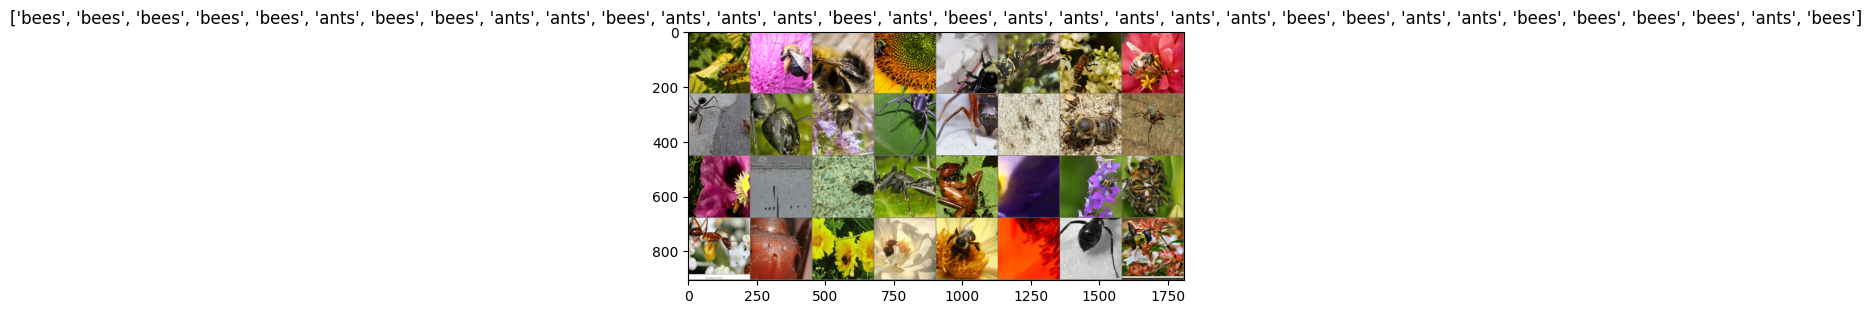

In [5]:
# Definieer de transformaties voor de training- en validatiesets
# Voor training doen we data-augmentatie (RandomResizedCrop, RandomHorizontalFlip)
# Voor validatie alleen de noodzakelijke transformaties (Resize, CenterCrop)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Maak de ImageFolder datasets
image_datasets = {x: datasets.ImageFolder(datadir / x, data_transforms[x])
                  for x in ['train', 'val']}

# Maak de DataLoaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Controle: Print de grootte van de datasets en de klassen
print(f"Trainingset grootte: {dataset_sizes['train']}")
print(f"Validatieset grootte: {dataset_sizes['val']}")
print(f"Klassen: {class_names}")

# Extra controle: Visualiseer een batch aan afbeeldingen om te zien of de data correct geladen wordt
import torchvision
import numpy as np

def imshow(inp, title=None):
    """Handige functie om een afbeelding te tonen"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Haal een batch trainingsdata op
inputs, classes = next(iter(dataloaders['train']))

# Maak een grid van de batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Building the Configurable CNN Model

This is the core of the project. I defined a ConfigurableCNN class that inherits from PyTorch's nn.Module.
- Configurable Architecture: Instead of using fixed values (e.g., nn.Conv2d(3, 16, ...)), the model's architecture is defined by a config dictionary passed during its creation. This allows us to easily change key hyperparameters like the number of filters in each convolutional layer (filters1, filters2), the dropout rate, and whether to use batch normalization.
- Model Layers: The architecture consists of two convolutional blocks for feature extraction, followed by fully connected layers for classification. MaxPool2d is used to downsample the feature maps, and Dropout is included as a regularization technique to prevent overfitting.

By building the model this way, Ray Tune can automatically create and test dozens of different architectures by simply providing different config dictionaries.

In [6]:
class ConfigurableCNN(nn.Module):
    def __init__(self, config: dict):
        super().__init__()
        
        # Leest de configuratie
        filters1 = config.get("filters1", 16)
        filters2 = config.get("filters2", 32)
        dropout_rate = config.get("dropout_rate", 0.25)
        use_batchnorm = config.get("use_batchnorm", True)
        fc_neurons = config.get("fc_neurons", 128)

        # Eerste convolutionele blok
        self.conv1 = nn.Conv2d(3, filters1, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(filters1) if use_batchnorm else nn.Identity()
        
        # Tweede convolutionele blok
        self.conv2 = nn.Conv2d(filters1, filters2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(filters2) if use_batchnorm else nn.Identity()
        
        # Algemene lagen
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=dropout_rate)
        
        # Classifier (Fully Connected lagen)
        # We moeten de input-grootte berekenen na de conv/pool lagen
        # Startgrootte: 224x224 -> na 2x poolen: 224/2/2 = 56x56
        self.fc1 = nn.Linear(filters2 * 56 * 56, fc_neurons)
        self.fc2 = nn.Linear(fc_neurons, 2) # 2 klassen: ants, bees

    def forward(self, x):
        # Doorlopen van de lagen
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        
        # Flatten voor de fully connected laag
        x = torch.flatten(x, 1)
        
        # Classifier
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Controle: Maak een model met een voorbeeldconfiguratie en print het
sample_config = {"filters1": 10, "filters2": 20, "dropout_rate": 0.5, "use_batchnorm": True, "fc_neurons": 100}
model = ConfigurableCNN(sample_config)
print(model)

ConfigurableCNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=62720, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


Creating the Training Function for Ray Tune

This train_model function encapsulates the entire training and validation loop for a single experiment (a "trial"). Ray Tune will call this function repeatedly with different hyperparameter configurations.
- Initialization: Inside the function, the model, optimizer (Adam), and loss function (CrossEntropyLoss) are created based on the config provided by Ray Tune for that specific trial.
- Training Loop: The model is trained for a fixed number of epochs (10). In each epoch, it first goes through the entire training dataset to learn (model.train()) and then evaluates its performance on the unseen validation dataset (model.eval()).
- Reporting: After the final epoch, the function reports the key metrics (accuracy and loss) back to Ray Tune using tune.report({...}). This is how Ray Tune knows how well each configuration performed.

I concluded the model with a "sanity check" by running this function once with a sample configuration to ensure there are no bugs before starting the full tuning process.

In [7]:
def train_model(config):
    # 1. Maak het model, de optimizer en de loss-functie
    model = ConfigurableCNN(config).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    criterion = nn.CrossEntropyLoss()
    
    # 2. Trainingsloop voor een vast aantal epochs
    for epoch in range(10): # We trainen elke trial voor 10 epochs
        # Training fase
        model.train()
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        # Validatie fase
        model.eval()
        val_loss = 0.0
        corrects = 0
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                corrects += torch.sum(preds == labels.data)

        epoch_loss = val_loss / dataset_sizes['val']
        epoch_acc = corrects.double() / dataset_sizes['val']
        
    # 3. Rapporteer de uiteindelijke metrieken aan Ray Tune
    tune.report({"accuracy": epoch_acc.item(), "loss": epoch_loss})

# Controle: Test de functie met dezelfde sample config
# Dit is een goede 'sanity check' om te zien of de trainingsloop werkt zonder Ray Tune
print("Start van de sanity check (kan even duren)...")
train_model({"lr": 0.001, **sample_config})
print("Sanity check voltooid. Als er geen errors zijn, is de functie klaar voor Ray Tune.")

Start van de sanity check (kan even duren)...
Sanity check voltooid. Als er geen errors zijn, is de functie klaar voor Ray Tune.


/Users/wouter/Documents/HAN/3_Deep_Learning_and_Model_Deployment/3_Afternoon_lessons/GIT/MADS-ML-WMvanHuis-1/.venv/lib/python3.12/site-packages/ray/train/_internal/session.py:657: UserWarning: `report` is meant to only be called inside a function that is executed by a Tuner or Trainer. Returning `None`.
  warnings.warn(


Experiment 1: Tuning Learning Rate and Filter Count

Here, we design and run our first experiment. The goal is to find a good starting point by tuning the most impactful hyperparameters first. I did the following:
- Hypothesis: The learning rate and the model's capacity (number of filters) will have a major impact on performance.
- search_space_exp1: This is to define the "search space" for Ray Tune. I used tune.grid_search to test every possible combination of three learning rates (lr) and three options for the number of filters in each of the two convolutional layers (filters1, filters2). This results in 3x3x3 = 27 total trials.
- Tuner.fit(): This command starts the experiment. Ray Tune manages the execution of all 27 trials.
- Analysis: The results are converted into a Pandas DataFrame for easy analysis. The top 5 performing configurations will be printed to get a quick overview.

In [8]:
# Definieer de zoekruimte voor het eerste experiment
search_space_exp1 = {
    "lr": tune.grid_search([1e-4, 1e-3, 1e-2]),
    "filters1": tune.grid_search([8, 16, 32]),
    "filters2": tune.grid_search([16, 32, 64]),
    "use_batchnorm": tune.grid_search([True]), # Vast voor dit experiment
    "dropout_rate": tune.grid_search([0.25]),  # Vast voor dit experiment
    "fc_neurons": tune.grid_search([128]),      # Vast voor dit experiment
}

from pathlib import Path

# Create an absolute path for the results directory
storage_path = Path.cwd() / "ray_results"

# Ray Tune opzetten en uitvoeren
tuner_exp1 = tune.Tuner(
    train_model,
    param_space=search_space_exp1,
    tune_config=tune.TuneConfig(
        metric="accuracy",
        mode="max",
        search_alg=BasicVariantGenerator(max_concurrent=4),
    ),
    run_config=air.RunConfig(
        name="experiment_1_lr_filters",
        storage_path=str(storage_path),  # Use the absolute path here
    )
)
results_exp1 = tuner_exp1.fit()

# Controle: Bekijk de resultaten als een DataFrame
df_exp1 = results_exp1.get_dataframe()
print("Top 5 beste resultaten van Experiment 1:")
print(df_exp1.sort_values("accuracy", ascending=False)[["accuracy", "loss", "config/lr", "config/filters1", "config/filters2"]].head())

2025-10-13 13:08:55,445	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/wouter/Documents/HAN/3_Deep_Learning_and_Model_Deployment/3_Afternoon_lessons/GIT/MADS-ML-WMvanHuis-1/4-hypertuning-ray/myproject/ray_results/experiment_1_lr_filters' in 0.0112s.
2025-10-13 13:08:55,450	INFO tune.py:1041 -- Total run time: 3424.37 seconds (3424.34 seconds for the tuning loop).


Top 5 beste resultaten van Experiment 1:
    accuracy      loss  config/lr  config/filters1  config/filters2
4   0.699346  0.612209     0.0001               16               32
8   0.699346  0.576763     0.0001               32               64
1   0.686275  0.622856     0.0001               16               16
22  0.679739  0.646555     0.0100               16               32
5   0.679739  0.604665     0.0001               32               32


Visualizing and Analyzing Experiment 1

A table of numbers can be hard to interpret. A visualization makes the relationships between hyperparameters and performance much clearer.
- Goal: To visualize the interaction between learning rate and filter count.
- Pivot Table: I restructured the results into a 2D grid (a pivot table) where the rows represent filters1, the columns represent lr, and the cell values represent the accuracy.
- Heatmap: I used Seaborn to create a heatmap from this pivot table. The color intensity immediately shows which combinations performed best (the "hot" yellow zones) and worst (the "cold" purple zones).

Conclusion: From the heatmap, we can easily identify the optimal learning rate and a good range for the filter count, which will then be used as the basis for the next experiment.

Beste waarde voor filters2 was: 32. We gebruiken dit voor de heatmap.


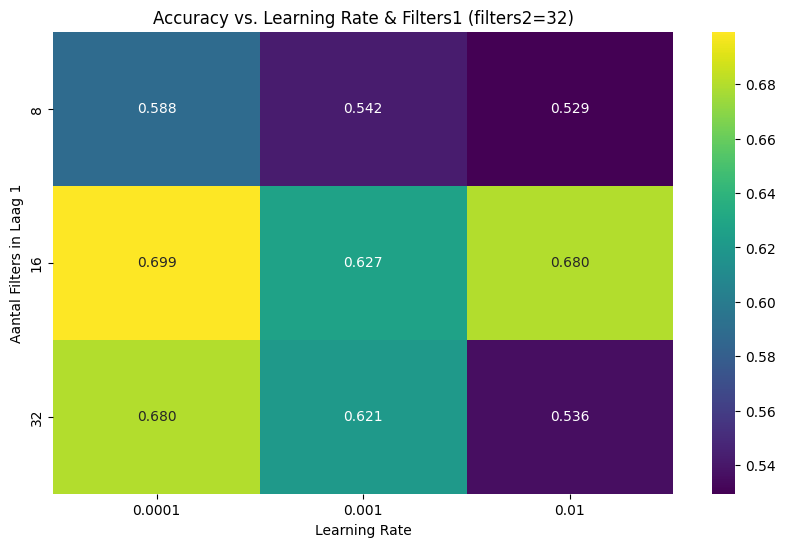

Beste configuratie gevonden in Experiment 1:
{'lr': 0.0001, 'filters1': 16, 'filters2': 32, 'use_batchnorm': True, 'dropout_rate': 0.25, 'fc_neurons': 128}


In [9]:
# We focussen op de interactie tussen lr en filters1, en houden filters2 vast op de beste waarde
best_filters2 = df_exp1.loc[df_exp1['accuracy'].idxmax()]['config/filters2']
print(f"Beste waarde voor filters2 was: {best_filters2}. We gebruiken dit voor de heatmap.")

# Maak een pivot table voor de heatmap
pivot_table = df_exp1[df_exp1['config/filters2'] == best_filters2].pivot_table(
    values='accuracy', 
    index='config/filters1', 
    columns='config/lr'
)

# Plot de heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis")
plt.title(f'Accuracy vs. Learning Rate & Filters1 (filters2={best_filters2})')
plt.xlabel('Learning Rate')
plt.ylabel('Aantal Filters in Laag 1')
plt.show()

# Analyse: Zoek de beste combinatie van hyperparameters uit deze run
best_config_exp1 = results_exp1.get_best_result(metric="accuracy", mode="max").config
print(f"Beste configuratie gevonden in Experiment 1:\n{best_config_exp1}")

Experiment 2: Impact of Dropout and Batch Normalization

Now that we have a good base model, we can investigate the effect of regularization techniques. This is an iterative approach: we narrow our search space and focus on fine-tuning. I did the following:
- Hypothesis: Batch Normalization and a moderate amount of Dropout will improve the model's ability to generalize and lead to higher accuracy.
- search_space_exp2: The model uses the best configuration from Experiment 1 as its foundation. We then vary only use_batchnorm (True or False) and the dropout_rate (0.0, 0.25, 0.5). This results in a focused experiment with 2x3 = 6 trials.
- Tuner.fit(): We run this second, smaller experiment.
- Analysis: Again the results are loaded into a DataFrame for inspection.

In [11]:
# Definieer de zoekruimte voor het tweede experiment
# We gebruiken de beste lr en filters uit het vorige experiment
search_space_exp2 = {
    "lr": tune.grid_search([best_config_exp1['lr']]),
    "filters1": tune.grid_search([best_config_exp1['filters1']]),
    "filters2": tune.grid_search([best_config_exp1['filters2']]),
    "fc_neurons": tune.grid_search([best_config_exp1['fc_neurons']]),
    
    # Dit zijn de variabelen die we nu onderzoeken
    "use_batchnorm": tune.grid_search([True, False]),
    "dropout_rate": tune.grid_search([0.0, 0.25, 0.5]),
}

# Create an absolute path for the results directory
storage_path = Path.cwd() / "ray_results"

tuner_exp2 = tune.Tuner(
    train_model,
    param_space=search_space_exp2,
    tune_config=tune.TuneConfig(
        metric="accuracy",
        mode="max",
        search_alg=BasicVariantGenerator(max_concurrent=2),
    ),
    run_config=air.RunConfig(
        name="experiment_2_dropout_bn",
        storage_path=str(storage_path),
    )
)
results_exp2 = tuner_exp2.fit()



# Controle: Bekijk de resultaten als een DataFrame
df_exp2 = results_exp2.get_dataframe()
print(df_exp2[["accuracy", "config/use_batchnorm", "config/dropout_rate"]])

2025-10-13 13:34:09,652	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/wouter/Documents/HAN/3_Deep_Learning_and_Model_Deployment/3_Afternoon_lessons/GIT/MADS-ML-WMvanHuis-1/4-hypertuning-ray/myproject/ray_results/experiment_2_dropout_bn' in 0.0061s.
2025-10-13 13:34:09,655	INFO tune.py:1041 -- Total run time: 1374.17 seconds (1374.15 seconds for the tuning loop).


   accuracy  config/use_batchnorm  config/dropout_rate
0  0.620915                  True                 0.00
1  0.712418                  True                 0.25
2  0.627451                  True                 0.50
3  0.601307                 False                 0.00
4  0.666667                 False                 0.25
5  0.647059                 False                 0.50


Visualisatie en Analyse van Experiment 2

<Figure size 1200x700 with 0 Axes>

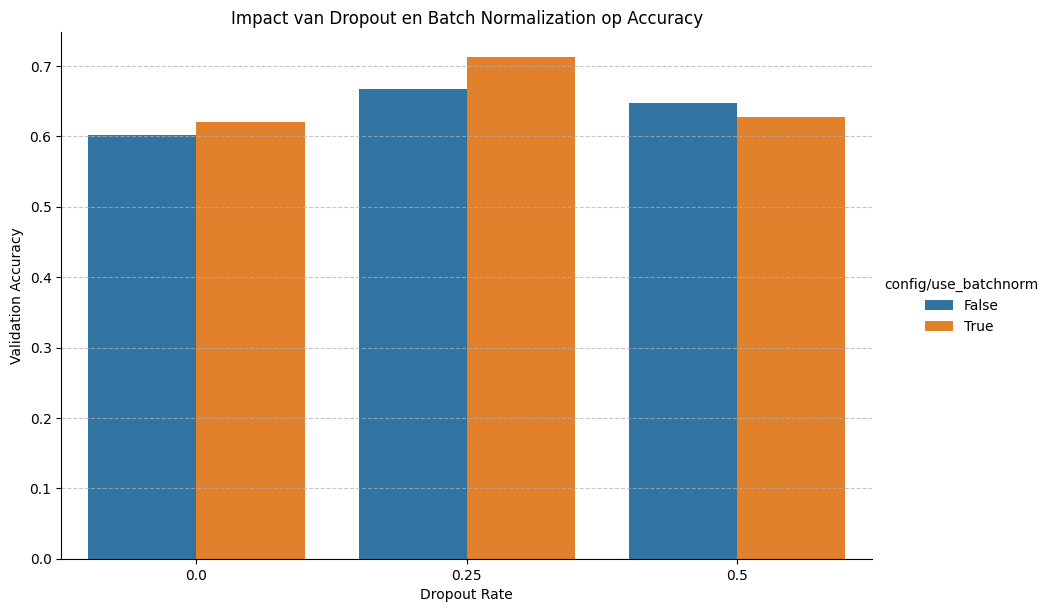

Uiteindelijke beste configuratie:
{'lr': 0.0001, 'filters1': 16, 'filters2': 32, 'fc_neurons': 128, 'use_batchnorm': True, 'dropout_rate': 0.25}


In [12]:
# Plot de resultaten
plt.figure(figsize=(12, 7))
sns.catplot(data=df_exp2, x="config/dropout_rate", y="accuracy", hue="config/use_batchnorm", kind="bar", height=6, aspect=1.5)
plt.title('Impact van Dropout en Batch Normalization op Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Analyse: Trek je conclusies
best_config_final = results_exp2.get_best_result(metric="accuracy", mode="max").config
print(f"Uiteindelijke beste configuratie:\n{best_config_final}")

Visualizing and Analyzing Experiment 2

To compare the discrete choices from Experiment 2, a bar chart is more suitable than a heatmap.
- Goal: To clearly compare the performance with/without Batch Normalization and across different dropout rates.
- Bar Chart (Catplot): I used Seaborn's catplot to create a grouped bar chart. This allows us to directly compare the accuracy of models with and without Batch Normalization for each dropout rate.

Conclusion: The visualization clearly shows the positive impact of both techniques. Now I can identify the single best-performing combination, which represents the final, optimized model configuration.